In [1]:
#! /usr/bin/env python
"""
Compute debris thickness through sub-debris and temperature inversion methods
"""
import sys
import os
import re
import subprocess
from datetime import datetime, timedelta
import time
import pickle
from collections import OrderedDict

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# from scipy import ndimage
# from scipy.optimize import curve_fit
from scipy.optimize import minimize
# from scipy.stats import median_absolute_deviation
import xarray as xr

import debrisglobal.globaldebris_input as debris_prms

In [2]:
data_source = 'regional'
# data_source = 'individual_glaciers'

# rois = ['11','12','13','14','15']
rois = ['11']

output_fp_noretreat = '/Users/davidrounce/Documents/Dave_Rounce/HiMAT/Output/cal_opt3/_4debrispaper/_noretreat/'
output_fp_wbnds = '/Users/davidrounce/Documents/Dave_Rounce/HiMAT/Output/cal_opt3/_4debrispaper/_bnds/'

roi_mbobs_dict = {'11': [-0.91, 0.70],
                  '12': [-0.88, 0.57],
                  '13': [-0.19, 0.15],
                  '14': [-0.11, 0.15],
                  '15': [-0.44, 0.15]}

In [3]:
def pickle_data(fn, data):
    """Pickle data
    
    Parameters
    ----------
    fn : str
        filename including filepath
    data : list, etc.
        data to be pickled
    
    Returns
    -------
    .pkl file
        saves .pkl file of the data
    """
    with open(fn, 'wb') as f:
        pickle.dump(data, f)

def process_reg_dif(output_fp_roi):
    mbclim_fns = []
    for i in os.listdir(output_fp_roi):
        if i.endswith('_mbclim_data.csv'):
            mbclim_fns.append(i)
    
    mbclim_fns = sorted(mbclim_fns)
    rgiids_wdebris = ['RGI60-' + x.split('_')[0].split('.')[0].zfill(2) + '.' + x.split('_')[0].split('.')[1] 
                      for x in mbclim_fns]
    rgino_str_wdebris = [x.split('-')[1] for x in rgiids_wdebris]
    
    main_glac_rgi_wdebris = debris_prms.selectglaciersrgitable(glac_no=rgino_str_wdebris)
    main_glac_rgi_wdebris['mbclim_fn'] = mbclim_fns
    
    print('ROI', roi, 'has', len(rgiids_wdebris), 'dc glaciers')
    
    mbclim_df_all = None
    reg_dc_area = 0
    for nglac, mbclim_fn in enumerate(mbclim_fns):
        mbclim_df = pd.read_csv(output_fp_roi + main_glac_rgi_wdebris.loc[nglac,'mbclim_fn'])
        mbclim_df['elev'] = [int(np.round(x,0)) for x in mbclim_df.elev.values]
        
        if mbclim_df_all is None:
            mbclim_df_all = mbclim_df
        else:
            mbclim_df_all = pd.concat([mbclim_df_all, mbclim_df], axis=0)
    mbclim_df_all.reset_index(inplace=True, drop=True)
    
    elev_min = mbclim_df_all.elev.min()
    elev_max = mbclim_df_all.elev.max()
    elev_bins_all = np.arange(elev_min, elev_max+5, 10)
    reg_mbclim_df = pd.DataFrame(np.zeros((len(elev_bins_all), len(mbclim_df.columns))), columns=mbclim_df.columns)
    for nelev, elev in enumerate(elev_bins_all):
        try:
            elev_idx = np.where(mbclim_df_all.elev.values == elev)[0]
        except:
            elev_idx = []
        
        if len(elev_idx) > 0:
            mbclim_df_all_subset = mbclim_df_all[mbclim_df_all.elev == elev]
            reg_subset_area = mbclim_df_all_subset.area.sum()
            reg_subset_mf = (mbclim_df_all_subset.mf * mbclim_df_all_subset.area).sum() / reg_subset_area
            reg_subset_mbclim_wdebris = ((mbclim_df_all_subset.mbclim_mwea_wdebris * mbclim_df_all_subset.area).sum() 
                                         / reg_subset_area)
            reg_subset_mbclim_nodebris = ((mbclim_df_all_subset.mbclim_mwea_nodebris * mbclim_df_all_subset.area).sum() 
                                          / reg_subset_area)
            reg_frontalablation = ((mbclim_df_all_subset.frontalablation * mbclim_df_all_subset.area).sum() 
                                   / reg_subset_area)
            reg_mbclim_df.loc[nelev,:] = [elev, reg_subset_area, reg_subset_mf, reg_subset_mbclim_wdebris, 
                                          reg_subset_mbclim_nodebris, reg_frontalablation]
            
    # ===== REGIONAL COMPUTATIONS ======
    reg_mbclim_wdebris_DC = (reg_mbclim_df.mbclim_mwea_wdebris * reg_mbclim_df.area).sum() / reg_mbclim_df.area.sum()
    reg_mbclim_nodebris_DC = (reg_mbclim_df.mbclim_mwea_nodebris * reg_mbclim_df.area).sum() / reg_mbclim_df.area.sum()

    main_glac_rgi_all = debris_prms.selectglaciersrgitable(rgi_regionsO1=[int(roi)], rgi_regionsO2='all',
                                                           rgi_glac_number='all')
    rgiids_all = list(main_glac_rgi_all.RGIId.values)
    rgiids_missing = set(rgiids_all) - set(rgiids_wdebris)
    rgino_str_missing = [x.split('-')[1] for x in rgiids_missing]
    main_glac_rgi_missing = debris_prms.selectglaciersrgitable(glac_no=rgino_str_missing)
    
    print('Debris-covered area only:')
    print('  mbclim (debris): ' + str(np.round(reg_mbclim_wdebris_DC,2)) + ' mwea')
    print('  mbclim (clean): ' + str(np.round(reg_mbclim_nodebris_DC,2)) + ' mwea')
    print(str(np.round(main_glac_rgi_missing.Area.sum() / main_glac_rgi_all.Area.sum() * 100)) + '%')
    print(str(np.round(reg_mbclim_df.area.sum() / main_glac_rgi_all.Area.sum() * 100)) + '%')
    print('reg_mbclim_df area:', reg_mbclim_df.area.sum())
    print('regional area:', main_glac_rgi_all.Area.sum())
    
    reg_mb_all = roi_mbobs_dict[roi][0]
    print(reg_mbclim_wdebris_DC, reg_mbclim_df.area.sum(), reg_mb_all, main_glac_rgi_missing.Area.sum())

    reg_mb_wdebris = ((reg_mbclim_wdebris_DC * reg_mbclim_df.area.sum() + 
                       reg_mb_all * main_glac_rgi_missing.Area.sum()) 
                      / (reg_mbclim_df.area.sum() + main_glac_rgi_missing.Area.sum()))
    reg_mb_nodebris = ((reg_mbclim_nodebris_DC * reg_mbclim_df.area.sum() + 
                        reg_mb_all * main_glac_rgi_missing.Area.sum()) 
                       / (reg_mbclim_df.area.sum() + main_glac_rgi_missing.Area.sum()))

    print('reg_mb_wdebris:', np.round(reg_mb_wdebris,2))
    print('reg_mb_nodebris:', np.round(reg_mb_nodebris,2),'\n\n')

            
    # ===== Plot regional curves ======
    # Only plot mass balance of bins with glacier (otherwise get streaks to 0 that aren't real)
    elev_bins = reg_mbclim_df.elev.values
    bins_area = reg_mbclim_df.area.values
    glacier_debrismf = reg_mbclim_df.mf.values
    glac_bin_massbalclim_annual_mean_wdebris = reg_mbclim_df.mbclim_mwea_wdebris.values
    glac_bin_massbalclim_annual_mean_nodebris = reg_mbclim_df.mbclim_mwea_nodebris.values
    
    return (bins_area, elev_bins, glacier_debrismf, reg_mb_wdebris, reg_mb_nodebris,
            glac_bin_massbalclim_annual_mean_wdebris, glac_bin_massbalclim_annual_mean_nodebris)

In [4]:
# ===== REGIONAL MBCLIM PLOTS ====================================================================================
process_regions = False
pickle_fp = output_fp_noretreat + 'pickle_datasets/'
if process_regions:
    # PyGEM HH2015 calibration with and without debris
    for nroi, roi in enumerate(rois):

        # ===== PROCESS THE NO RETREAT DATA ======
        output_fp_roi = output_fp_noretreat + data_source + '-mbclim/' + roi + '/'
        (bins_area, elev_bins, glacier_debrismf, reg_mb_wdebris, reg_mb_nodebris, 
         glac_bin_massbalclim_annual_mean_wdebris, glac_bin_massbalclim_annual_mean_nodebris) = (
            process_reg_dif(output_fp_roi))
        # ----- LOWER BOUND -----
        output_fp_roi_bndlow = output_fp_wbnds + 'bndlow_' + data_source + '-mbclim/' + roi + '/'
        (bins_area_bndlow, elev_bins_bndlow, glacier_debrismf_bndlow, reg_mb_wdebris_bndlow, reg_mb_nodebris_bndlow, 
         glac_bin_massbalclim_annual_mean_wdebris_bndlow, glac_bin_massbalclim_annual_mean_nodebris_bndlow) = (
            process_reg_dif(output_fp_roi_bndlow))
        # ----- UPPER BOUND -----
        output_fp_roi_bndhigh = output_fp_wbnds + 'bndhigh_' + data_source + '-mbclim/' + roi + '/'
        (bins_area_bndhigh, elev_bins_bndhigh, glacier_debrismf_bndhigh, reg_mb_wdebris_bndhigh, reg_mb_nodebris_bndhigh, 
         glac_bin_massbalclim_annual_mean_wdebris_bndhigh, glac_bin_massbalclim_annual_mean_nodebris_bndhigh) = (
            process_reg_dif(output_fp_roi_bndhigh))


        bins_idx = np.where(bins_area > 0)[0]
        # ELA for each plot
        ela = elev_bins[np.abs(glac_bin_massbalclim_annual_mean_wdebris[bins_idx]).argmin()]

        fig, ax = plt.subplots(1, 3, squeeze=False, sharex=False, sharey=True, gridspec_kw={'wspace':0.1,'hspace':0})

        mbclim_wdebris_4fig = "{:.2f}".format(reg_mb_wdebris)
        mbclim_nodebris_4fig = "{:.2f}".format(reg_mb_nodebris)
        bins_idx = np.where(bins_area > 0)[0]

        # Dictionary (bclim_major, bclim_minor, elev_major, elev_minor, area_max)
        roi_mbclim_dict = {'11': [1000, 200, -8, 2, 5, 1, 10, 2, 28],
                           '12': [1000, 200, -8, 2, 2, 0.5, 5, 1, 13],
                           '13': [1000, 200, -8, 2, 5, 1, 50, 10, 130],
                           '14': [1000, 200, -8, 2, 5, 1, 50, 10, 180],
                           '15': [1000, 200, -8, 2, 5, 1, 25, 5, 95]}
        handlelength=1
        handletextpad=0.2

        # Mass balance gradients
        ax[0,0].plot(glac_bin_massbalclim_annual_mean_wdebris[bins_idx], elev_bins[bins_idx], 
                     color='g', linewidth=1, zorder=2, label='Debris\n(' + mbclim_wdebris_4fig + ')')
        ax[0,0].plot(glac_bin_massbalclim_annual_mean_nodebris[bins_idx], elev_bins[bins_idx], 
                     color='b', linewidth=1, zorder=1, label='No debris\n(' + mbclim_nodebris_4fig + ')')
        ax[0,0].axvline(x=0, color='k', linewidth=0.5)
        ax[0,0].axhline(y=ela, color='k', linestyle=':', linewidth=0.5)
        # X label
        ax[0,0].set_xlabel('$b_{clim}$ (m w.e. a$\mathregular{^{-1}}$)', size=12)
        ax[0,0].set_xlim(-8)
        ax[0,0].xaxis.set_major_locator(plt.MultipleLocator(roi_mbclim_dict[roi][4]))
        ax[0,0].xaxis.set_minor_locator(plt.MultipleLocator(roi_mbclim_dict[roi][5]))
        # Y label
        ax[0,0].set_ylabel('Elevation (m a.s.l.)', size=12)    
        ax[0,0].set_ylim(elev_bins.min() - 10, elev_bins.max() + 10)
        ax[0,0].yaxis.set_major_locator(plt.MultipleLocator(roi_mbclim_dict[roi][0]))
        ax[0,0].yaxis.set_minor_locator(plt.MultipleLocator(roi_mbclim_dict[roi][1]))
        ax[0,0].legend(loc='upper left', bbox_to_anchor=(0.09, 1.02), handlelength=handlelength, handletextpad=handletextpad)
        # ---- bounds -----
        ax[0,0].fill_betweenx(elev_bins[bins_idx],
                              glac_bin_massbalclim_annual_mean_wdebris_bndlow[bins_idx], 
                              glac_bin_massbalclim_annual_mean_wdebris_bndhigh[bins_idx],
                              color='g', linewidth=0, zorder=3, alpha=0.2)
        ax[0,0].fill_betweenx(elev_bins[bins_idx],
                              glac_bin_massbalclim_annual_mean_nodebris_bndlow[bins_idx], 
                              glac_bin_massbalclim_annual_mean_nodebris_bndhigh[bins_idx],
                              color='b', linewidth=0, zorder=3, alpha=0.2)
        ax[0,0].tick_params(axis='both', which='major', direction='inout')
        ax[0,0].tick_params(axis='both', which='minor', direction='in') 

        # Glacier hypsometry
        ax[0,1].plot(bins_area[bins_idx], elev_bins[bins_idx], color='k', linewidth=1, zorder=1)
        ax[0,1].axhline(y=ela, color='k', linestyle=':', linewidth=0.5)
        ax[0,1].set_xlabel('Area ($\mathregular{km^{2}}$)', size=12)
        ax[0,1].set_xlim(0,roi_mbclim_dict[roi][8])
        ax[0,1].xaxis.set_major_locator(plt.MultipleLocator(roi_mbclim_dict[roi][6]))
        ax[0,1].xaxis.set_minor_locator(plt.MultipleLocator(roi_mbclim_dict[roi][7]))
        ax[0,1].tick_params(axis='both', which='major', direction='inout')
        ax[0,1].tick_params(axis='both', which='minor', direction='in') 

        ax2 = ax[0,1].twiny()
        ax2.set_xlim(0,1)
        bins_area_cumsum = np.cumsum(bins_area)
        ax2.plot(bins_area_cumsum / bins_area.sum(), elev_bins, label='$AAD_{cum}$')
        ax2.legend(loc='upper left', bbox_to_anchor=(0.2, 1.02), handlelength=handlelength, handletextpad=handletextpad)

        # Debris thickness
        ax[0,2].plot(glacier_debrismf[bins_idx], elev_bins[bins_idx], color='k', linewidth=1, zorder=1)
        ax[0,2].axhline(y=ela, color='k', linestyle=':', linewidth=0.5)
        ax[0,2].set_xlabel('$E_{debris}$')
        ax[0,2].set_xlim(0,1.25)
        ax[0,2].xaxis.set_major_locator(plt.MultipleLocator(0.5))
        ax[0,2].xaxis.set_minor_locator(plt.MultipleLocator(0.1))  
        # ---- bounds -----
        ax[0,2].fill_betweenx(elev_bins[bins_idx],
                              glacier_debrismf_bndlow[bins_idx], glacier_debrismf_bndhigh[bins_idx],
                              color='k', linewidth=0, zorder=3, alpha=0.2, label='')
        ax[0,2].tick_params(axis='both', which='major', direction='inout')
        ax[0,2].tick_params(axis='both', which='minor', direction='in') 

        # Labels
        ax[0,0].text(0.12, 0.98, 'a', size=12, fontweight='bold',
                    horizontalalignment='right', verticalalignment='top', transform=ax[0,0].transAxes)
        ax[0,1].text(0.12, 0.98, 'b', size=12, fontweight='bold',
                    horizontalalignment='right', verticalalignment='top', transform=ax[0,1].transAxes)
        ax[0,2].text(0.12, 0.98, 'c', size=12, fontweight='bold',
                    horizontalalignment='right', verticalalignment='top', transform=ax[0,2].transAxes)

        # Save plot
        fig.set_size_inches(6, 3)
        fig_fp = output_fp_noretreat + 'debris_figs/'
        if not os.path.exists(fig_fp):
            os.makedirs(fig_fp)
        fig_fn = roi + '_mbgrad_debris.png'
        fig.savefig(fig_fp + fig_fn, bbox_inches='tight', dpi=300, transparent=True)

        # Save data so only have to process once
        roi_data_list = []
        roi_data_list.append(bins_area)
        roi_data_list.append(elev_bins)
        roi_data_list.append(glacier_debrismf)
        roi_data_list.append(reg_mb_wdebris)
        roi_data_list.append(reg_mb_nodebris)
        roi_data_list.append(glac_bin_massbalclim_annual_mean_wdebris)
        roi_data_list.append(glac_bin_massbalclim_annual_mean_nodebris)
        roi_data_list.append(glacier_debrismf_bndlow)
        roi_data_list.append(reg_mb_wdebris_bndlow)
        roi_data_list.append(reg_mb_nodebris_bndlow)
        roi_data_list.append(glac_bin_massbalclim_annual_mean_wdebris_bndlow)
        roi_data_list.append(glac_bin_massbalclim_annual_mean_nodebris_bndlow)
        roi_data_list.append(glacier_debrismf_bndhigh)
        roi_data_list.append(reg_mb_wdebris_bndhigh)
        roi_data_list.append(reg_mb_nodebris_bndhigh)
        roi_data_list.append(glac_bin_massbalclim_annual_mean_wdebris_bndhigh)
        roi_data_list.append(glac_bin_massbalclim_annual_mean_nodebris_bndhigh)
        
        # Load file if it already exists
        if not os.path.exists(pickle_fp):
            os.makedirs(pickle_fp)
        roi_data_list_fullfn = pickle_fp + roi + '_pygem_mbdif_data.pkl'
        pickle_data(roi_data_list_fullfn, roi_data_list)


In [10]:
# Debris area-altitude distribution
rois = ['11','12','13','14','15']
mb_bins_fp = debris_prms.output_fp + 'mb_bins/csv/'
process_bins = False

if process_bins:
    for nroi, roi in enumerate(rois):
        mb_fn_roi_all = []
        for i in os.listdir(mb_bins_fp):
            if i.endswith('.csv'):
                if int(i.split('.')[0]) == int(roi):
                    mb_fn_roi_all.append(i)
        mb_fn_roi_all = sorted(mb_fn_roi_all)

        mb_bins_df_all = None
        for i in mb_fn_roi_all:
            mb_bins_df = pd.read_csv(mb_bins_fp + i)
            mb_bins_df['bin_center_elev_m'] = [int(np.round(x,0)) for x in mb_bins_df.bin_center_elev_m.values]

            if mb_bins_df_all is None:
                mb_bins_df_all = mb_bins_df
            else:
                mb_bins_df_all = pd.concat([mb_bins_df_all, mb_bins_df], axis=0)
        mb_bins_df_all.reset_index(inplace=True, drop=True)

        elev_min = mb_bins_df_all.bin_center_elev_m.min()
        elev_max = mb_bins_df_all.bin_center_elev_m.max()
        elev_bins_all = np.arange(elev_min, elev_max+5, 10)
        mb_bins_cns = ['elev', 'dc_area', 'area']
        reg_mb_bins_df = pd.DataFrame(np.zeros((len(elev_bins_all), len(mb_bins_cns))), columns=mb_bins_cns)
        for nelev, elev in enumerate(elev_bins_all):
            try:
                elev_idx = np.where(mb_bins_df_all.bin_center_elev_m.values == elev)[0]
            except:
                elev_idx = []

            if len(elev_idx) > 0:
                mb_bins_df_all_subset = mb_bins_df_all[mb_bins_df_all.bin_center_elev_m == elev]
                reg_subset_area_dc = mb_bins_df_all_subset.dc_bin_area_valid_km2.sum()
                reg_subset_area = mb_bins_df_all_subset.z1_bin_area_valid_km2.sum()
                reg_mb_bins_df.loc[nelev,:] = [elev, reg_subset_area_dc, reg_subset_area]

        reg_mb_bins_fn = roi + '_dc_area_distribution.csv'
        reg_mb_bins_df.to_csv(pickle_fp + reg_mb_bins_fn, index=False)

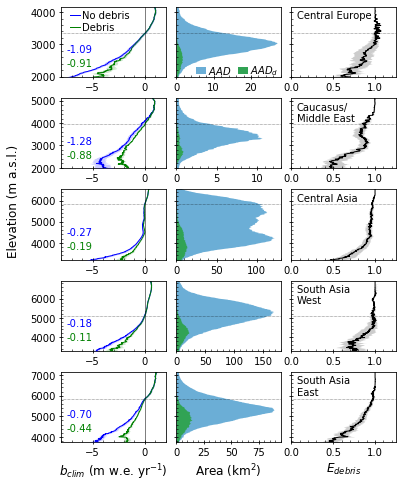

In [59]:
# ===== PLOT FOR PAPER =====
rois = ['11','12','13','14','15']
# rois = ['11']

fig, ax = plt.subplots(len(rois), 3, squeeze=False, sharex=False, sharey=False, gridspec_kw={'wspace':0.1,'hspace':0.3})

for nroi, roi in enumerate(rois):
    
    # Load data
    roi_data_list_fullfn = pickle_fp + roi + '_pygem_mbdif_data.pkl'
    assert os.path.exists(roi_data_list_fullfn), 'No pickled data available; process roi first'
    with open(roi_data_list_fullfn, 'rb') as f:
        roi_data_list = pickle.load(f)
    
    dc_aad_fullfn = pickle_fp + roi + '_dc_area_distribution.csv'
    assert os.path.exists(dc_aad_fullfn), 'Area-altitude distribution for roi does not exist'
    dc_aad_df = pd.read_csv(dc_aad_fullfn)
    
    bins_area = roi_data_list[0]
    elev_bins = roi_data_list[1]
    glacier_debrismf = roi_data_list[2]
    reg_mb_wdebris = roi_data_list[3]
    reg_mb_nodebris = roi_data_list[4]
    glac_bin_massbalclim_annual_mean_wdebris = roi_data_list[5]
    glac_bin_massbalclim_annual_mean_nodebris = roi_data_list[6]
    glacier_debrismf_bndlow = roi_data_list[7]
    reg_mb_wdebris_bndlow = roi_data_list[8]
    reg_mb_nodebris_bndlow = roi_data_list[9]
    glac_bin_massbalclim_annual_mean_wdebris_bndlow = roi_data_list[10]
    glac_bin_massbalclim_annual_mean_nodebris_bndlow = roi_data_list[11]
    glacier_debrismf_bndhigh = roi_data_list[12]
    reg_mb_wdebris_bndhigh = roi_data_list[13]
    reg_mb_nodebris_bndhigh = roi_data_list[14]
    glac_bin_massbalclim_annual_mean_wdebris_bndhigh = roi_data_list[15]
    glac_bin_massbalclim_annual_mean_nodebris_bndhigh = roi_data_list[16]
        
    
    bins_idx = np.where(bins_area > 0)[0]
    # ELA for each plot
    ela = elev_bins[np.abs(glac_bin_massbalclim_annual_mean_wdebris[bins_idx]).argmin()]
    
    # Normalized cumulative area
    bins_area_cumsum_norm = np.cumsum(bins_area) / bins_area.sum()
    bins_area_dc_cumsum_norm = np.cumsum(dc_aad_df.dc_area.values) / dc_aad_df.dc_area.sum()
    
    # bounds
    ymin = elev_bins[np.where(bins_area_cumsum_norm > 0.005)[0][0]]
    ymax = elev_bins[np.where(bins_area_cumsum_norm < 0.995)[0][-1]]
    
    mbclim_wdebris_4fig = "{:.2f}".format(reg_mb_wdebris)
    mbclim_nodebris_4fig = "{:.2f}".format(reg_mb_nodebris)
    bins_idx = np.where(bins_area > 0)[0]
    
    # Dictionary (elev_major, elev_minor, bclim_major, bclim_minor,  area_max)
    roi_mbclim_dict = {'11': [1000, 200, -8, 2, 5, 1, 10, 2, 28],
                       '12': [1000, 200, -8, 2, 5, 1, 5, 1, 13],
                       '13': [1000, 200, -8, 2, 5, 1, 50, 10, 130],
                       '14': [1000, 200, -8, 2, 5, 1, 50, 10, 180],
                       '15': [1000, 200, -8, 2, 5, 1, 25, 5, 95]}
    handlelength=1
    handletextpad=0.2
    
    # Mass balance gradients
    ax[nroi,0].plot(glac_bin_massbalclim_annual_mean_nodebris[bins_idx], elev_bins[bins_idx], 
                    color='b', linewidth=1, zorder=1, label='No debris')
    ax[nroi,0].plot(glac_bin_massbalclim_annual_mean_wdebris[bins_idx], elev_bins[bins_idx], 
                    color='g', linewidth=1, zorder=2, label='Debris')
    ax[nroi,0].axvline(x=0, color='k', linewidth=0.5)
    ax[nroi,0].axhline(y=ela, color='k', linestyle=':', linewidth=0.5)
    # bounds
    ax[nroi,0].fill_betweenx(elev_bins[bins_idx],
                             glac_bin_massbalclim_annual_mean_wdebris_bndlow[bins_idx], 
                             glac_bin_massbalclim_annual_mean_wdebris_bndhigh[bins_idx],
                             color='g', linewidth=0, zorder=3, alpha=0.2)
    ax[nroi,0].fill_betweenx(elev_bins[bins_idx],
                             glac_bin_massbalclim_annual_mean_nodebris_bndlow[bins_idx], 
                             glac_bin_massbalclim_annual_mean_nodebris_bndhigh[bins_idx],
                             color='b', linewidth=0, zorder=3, alpha=0.2)
    # Regional mass balance values - text
    ax[nroi,0].text(0.05, 0.35, mbclim_nodebris_4fig, color='b', transform=ax[nroi,0].transAxes, size=10)
    ax[nroi,0].text(0.05, 0.15, mbclim_wdebris_4fig, color='g', transform=ax[nroi,0].transAxes, size=10)  
    # X label
    if nroi == len(rois) - 1:
        ax[nroi,0].set_xlabel('$b_{clim}$ (m w.e. yr$\mathregular{^{-1}}$)', size=12)
    ax[nroi,0].set_xlim(-8,2)
    ax[nroi,0].xaxis.set_major_locator(plt.MultipleLocator(roi_mbclim_dict[roi][4]))
    ax[nroi,0].xaxis.set_minor_locator(plt.MultipleLocator(roi_mbclim_dict[roi][5]))
    # Y label
    for ncol in [0,1,2]:
        ax[nroi,ncol].set_ylim(elev_bins.min() - 10, elev_bins.max() + 10)
        ax[nroi,ncol].yaxis.set_major_locator(plt.MultipleLocator(roi_mbclim_dict[roi][0]))
        ax[nroi,ncol].yaxis.set_minor_locator(plt.MultipleLocator(roi_mbclim_dict[roi][1]))
        ax[nroi,ncol].tick_params(axis='both', which='major', direction='inout')
        ax[nroi,ncol].tick_params(axis='both', which='minor', direction='in')
        ax[nroi,ncol].set_ylim(ymin, ymax)
    for ncol in [1,2]:
        ax[nroi,ncol].get_yaxis().set_ticklabels([])
    if nroi == 0:
        ax[nroi,0].legend(loc='upper left', bbox_to_anchor=(0., 1.08), frameon=False,
                          handlelength=handlelength, handletextpad=handletextpad, labelspacing=0.2)
    
    # ----- Glacier hypsometry -----
    ax[nroi,1].fill_betweenx(elev_bins[bins_idx],
                             0, bins_area[bins_idx],
                             color='#6baed6', linewidth=0, zorder=1, alpha=1, label='$AAD$')
    ax[nroi,1].fill_betweenx(dc_aad_df.elev,
                             0, dc_aad_df.dc_area,
                             color='#31a354', linewidth=0, zorder=1, alpha=1, label='$AAD_{d}$')
    ax[nroi,1].axhline(y=ela, color='k', linestyle=':', linewidth=0.5, zorder=3)
    if nroi == len(rois) - 1:
        ax[nroi,1].set_xlabel('Area ($\mathregular{km^{2}}$)', size=12)
    ax[nroi,1].set_xlim(0,roi_mbclim_dict[roi][8])
    ax[nroi,1].xaxis.set_major_locator(plt.MultipleLocator(roi_mbclim_dict[roi][6]))
    ax[nroi,1].xaxis.set_minor_locator(plt.MultipleLocator(roi_mbclim_dict[roi][7]))
#     # cumulative AAD
#     ax2 = ax[nroi,1].twiny()
#     ax2.set_xlim(0,1)
#     ax2.plot(bins_area_cumsum_norm, elev_bins, label='$AAD_{cum}$', color='k')
# #     ax2.plot(bins_area_dc_cumsum_norm, dc_aad_df.elev.values, label='$AAD_{cum,d}$', color='#31a354')
#     ax2.xaxis.set_major_locator(plt.MultipleLocator(0.5))
#     ax2.xaxis.set_minor_locator(plt.MultipleLocator(0.25))
#     ax2.tick_params(axis='x', which='major', direction='inout')
#     ax2.tick_params(axis='x', which='minor', direction='in') 
    if nroi == 0:
#         ax2.legend(loc='upper left', bbox_to_anchor=(0.2, 1.02), frameon=False,
#                    handlelength=handlelength, handletextpad=handletextpad)
        ax[nroi,1].legend(loc='upper left', bbox_to_anchor=(0.1, 0.32), frameon=False,
                          handlelength=handlelength, handletextpad=handletextpad, ncol=2, columnspacing=0.7)
    if nroi > 0:
        ax2.get_xaxis().set_ticklabels([])
        

    # ----- Enhancement factors -----
    ax[nroi,2].plot(glacier_debrismf[bins_idx], elev_bins[bins_idx], color='k', linewidth=1, zorder=1)
    ax[nroi,2].axhline(y=ela, color='k', linestyle=':', linewidth=0.5)
    if nroi == len(rois) - 1:
        ax[nroi,2].set_xlabel('$E_{debris}$', size=12)
    ax[nroi,2].set_xlim(0,1.25)
    ax[nroi,2].xaxis.set_major_locator(plt.MultipleLocator(0.5))
    ax[nroi,2].xaxis.set_minor_locator(plt.MultipleLocator(0.1))  
    # bounds
    ax[nroi,2].fill_betweenx(elev_bins[bins_idx],
                             glacier_debrismf_bndlow[bins_idx], glacier_debrismf_bndhigh[bins_idx],
                             color='k', linewidth=0, zorder=3, alpha=0.2, label='')        
    # Regions
    roi_name_dict = {'11':'Central Europe',
                     '12':'Caucasus/\nMiddle East',
                     '13':'Central Asia',
                     '14':'South Asia\nWest',
                     '15':'South Asia\nEast'}
    ax[nroi,2].text(0.05, 0.95, roi_name_dict[roi], color='k', transform=ax[nroi,2].transAxes, va='top', ha='left',
                    size=10)

fig.text(0,0.45,'Elevation (m a.s.l.)', rotation=90, size=12)    

# Save plot
fig_height = 8
fig.set_size_inches(6, fig_height)
fig_fp = output_fp_noretreat + 'debris_figs/'
if not os.path.exists(fig_fp):
    os.makedirs(fig_fp)
fig_fn = 'all_mbgrad_debris.png'
fig.savefig(fig_fp + fig_fn, bbox_inches='tight', dpi=300, transparent=True)